# Variational Quantum Eigensolver

## Gabriel Oliveira Alves

# Task 4

Find the lowest eigenvalue of the following matrix:

\begin{equation}
\begin{matrix}
\begin{pmatrix}
1 & 0 & 0 & 0\\
0& 0 & -1 & 0\\
0& -1 & 0 & 0\\
0 & 0 & 0 & 1\\
\end{pmatrix}
\end{matrix}
\end{equation}

using VQE-like circuits, created by yourself from scratch.

# Summary

I will divide this task into four sections:
    
> Introduction

- Conventions, notations and the Qiskit Library

> A first implementation

- A simple example for a 2 x 2 matrix

> The task

- A short comment on the ansatz choice and the implementation

> Comments and Generalizations

- Final comments and two further examples

The results of the task itself are all contained in section three, but I thought I would be useful to add two short sections first, where I talk about a simpler example for a single qubit and the qiskit library

### References:

- https://qiskit.org/textbook/ch-states/introduction.html
- https://qiskit.org/documentation/tutorials/circuits_advanced/1_advanced_circuits.html
- https://www.mustythoughts.com/variational-quantum-eigensolver-explained
- https://github.com/mstechly/mustythoughts_plus/blob/master/VQE_QAOA/VQE_explained_example.ipynb
- https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb

# 1. Introduction

To solve the task I used mainly the qiskit library for quantum computing and numpy for numerics. I also used Mathematica in a certain segment to discuss the physics in a bit more detail. Here I'll talk briefly about the Qiskit library, notation conventions and so on. 

This cell is used to run a sample circuit, briefly discussing the main properties and commands of the qiskit library


The counts in this experiment for this circuit for 00 and 01 are: {'00': 494, '01': 506}


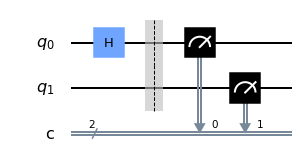

In [1]:
import numpy as np
from qiskit import *

# Here we define the backend to plot the circuit. We could also use a backend for wave vectors, unitaries and so on, as we'll soon see
backend = Aer.get_backend('qasm_simulator')

# Creates a Quantum Circuit with n qubits and m classical bits
circuit = QuantumCircuit(2, 2)

# The notation circuit.gate() is used to add a gate to the circuit. In this case, a Haddamard gate
circuit.h(0)

# Here we apply a barrier into this point of the circuit
circuit.barrier()

# Map the quantum measurement to the classical bits. Here circuit.measure(n, m) maps the measurement of the n-th qubit to the m-th classical bit
circuit.measure(0, 0)
circuit.measure(1, 1)

# Executes the circuit on the qasm simulator with a certain ensemble size
job = execute(circuit, backend, shots=1000)

# Grabs results from the job
result = job.result()

# Returns counts. This determines the probability distribution for the wave function
counts = result.get_counts(circuit)
print("\nThe counts in this experiment for this circuit for 00 and 01 are:",counts)

# Draws the circuit
circuit.draw('mpl')

### Binding parameter to the circuits

Here I show how to parametrize gates in a quantum circuit using quskit, this will be important to define an Ansatz. What we do through the VQE is simply to set up a quantum circuit which is able to parametrize certain classes of wave functions. We can then reduce the eigenproblem to a minimization problem, where we try to find a global minimum for the expected value of a certain observable. In other words, we parametrize the wave function through

\begin{equation}
|\psi\rangle = U(\theta_1, ..., \theta_n) |0\rangle \otimes...\otimes |0\rangle
\end{equation}

And to find the lowest eigenvalue of $H$ we simply minimize

\begin{equation}
E(\theta_1, ..., \theta_n) = \langle\psi| H |\psi\rangle 
\end{equation}

Thus, this functionality of QiSkit is useful to parametrize the ground state energy. After we set up the quantum circuit we simply look for the optimal values of $\theta_i$, this can be done either through brute-force or a more robust method like gradient descent. Below I show how to do this for a single gate:

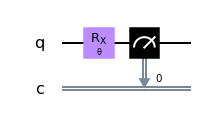

In [2]:
from qiskit.circuit import Parameter

# Here we define a parameters. The string in Parameter(...) is the string which will appear in the circuit drawing
theta = Parameter('θ')
qc = QuantumCircuit(1, 1)

# Here we define a parametrized gate
qc.rx(theta, 0)
qc.measure(0, 0)

# This is the circuit before we bind the parameter
qc.draw('mpl')

We can assign a numerical value for this parameter:

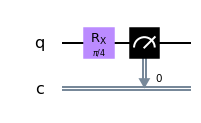

In [3]:
# Now we bind the parameters, we are simply defining theta numerically this time. Note that this can also be done with a list
qc = qc.bind_parameters({theta:np.pi/4})
qc.draw('mpl')

### 1.1 Getting wave functions as an output

By choosing the appropriate backend, the qiskit library also let us to numerically determine the corresponding wave function for the quantum circuit. Here we initialize a qubit in the ground state and then apply the Haddamard Gate:

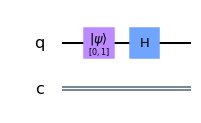

In [4]:
qc = QuantumCircuit(1, 1) 

# Defines the initial_state as |1>
initial_state = [0, 1]  

# Initializes the 0-th qubit
qc.initialize(initial_state, 0) 

# We apply a Haddamard gate
qc.h(0)

qc.draw('mpl')

Picking a specific backend and display the result w.f.:

In [6]:
# Using the AER backend here raises an error
backend = Aer.get_backend('statevector_simulator')

# Performs the simulation, returning the result
result = execute(qc, backend).result()
out_state = result.get_statevector()

# Displays the output state vector. We can see that we got |psi> = (|0> - |1>)/sqrt(2) as expected
print(out_state) 

[ 0.70710678-8.65956056e-17j -0.70710678+8.65956056e-17j]


# 2. A first implementation - simple example

Here we try to apply the VQE for the matrix $H = \sigma_z + \sigma_x$, which is

\begin{equation}
H
=
\sigma_z + \sigma_x
=
\begin{matrix}
\begin{pmatrix}
1 &  1\\
1 & -1
\end{pmatrix}
\end{matrix}
\end{equation}

First of all we will begin
with an ansatz of the type:

$| \psi \rangle = R_Y(\theta)| 0 \rangle$

The lowest eigenvalues of this matrix is given by $\lambda = \sqrt{2}$ and the corresponding eigenvector is $v_\lambda = (-0.382683, 0.92388)$

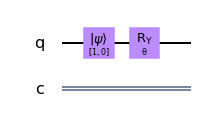

In [11]:
# We create two circuits with a single qubit
qc1 = QuantumCircuit(1, 1)
qc2 = QuantumCircuit(1, 1)

# We parametrize the wave function with a Y gate
qc1.initialize([1, 0], 0) 
qc2.initialize([1, 0], 0) 
theta = Parameter('θ')

# We add gates to each circuit. We should remember that RY(theta) in the qiskit library actually rotates by an angle of 2*theta when we compare it
# with the usual convention
qc1.ry(theta, 0)
qc2.ry(theta, 0)

qc1.draw('mpl')

We have a "problem" here. We are only able to perform measurements in the computational basis. So, if we measure $0$ we know that we got the eigenvalue $+1$ for $\sigma_z$, and analogously, if we measure $1$, we know the corresponding eigenvalue is $+1$ (or the other way around, depending on the convention). But what about the other Pauli Matrices? What we can do is the following: we rotate the Bloch Sphere in $-\pi/2$ degress, so the eigenstates $|+\rangle$ and $|-\rangle$ of the Pauli Matrix $\sigma_x$ will become $|0\rangle$ and $|1\rangle$ respectively. It's clear where the problem arises - we have to perform measurements in a orthogonal eigenbasis of our operator. Without any adjustements we are not capable of distiguishing the states  $|+\rangle$ and  $|-\rangle$ for example, when measuring only the probabilities $|c_0|^2$ and $|c_1|^2$. 

Thus, our workaround is to introduce an extra $RY$ gate to the circuit so we can properly measure the energy contribution from the $\sigma_X$ term in the Hamiltonian

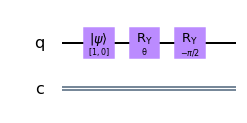

In [12]:
qc2.ry(-np.pi/2, 0)

qc2.draw('mpl')

We'll perform the experiment for several values of theta in the interval $\theta \in [0, 2\pi]$. This let us construct several circuits, one for each value of $\theta$

In [13]:
# Runs a circuit simulation by binding a certain parameters numerically
def execute_parametrized_circuit(circuit, backend_choice, size, parameter, parameter_range):
    return execute(circuit,
              backend_choice, 
              shots = size,
              parameter_binds=[{parameter: val} for val in parameter_range])


# We define a numpy vector with theta ranging from 0 to 2 pi
theta_range = np.linspace(0.0, 2 * np.pi, n_experiments := 200)

# We define an ensemble size
num_shots = 10000

# We pick the simulator for wave functions
backend = Aer.get_backend('statevector_simulator')

# We create several circuits with a binded parameter for a certain value of theta from the array above
job1 = execute_parametrized_circuit(qc1, backend, num_shots, theta, theta_range)
job2 = execute_parametrized_circuit(qc2, backend, num_shots, theta, theta_range)

We can get the resulting wave-vector from each experiment. This allow us to compute the expected value of any observable for different values of $\theta$

In [14]:
wave_function = [job1.result().get_statevector(i) for i in range (n_experiments)]

Now we can perform a measurement (this should be done _after_ we record the wave functions otherwise we will simply collapse them after the measurements). We draw the second circuit as an example

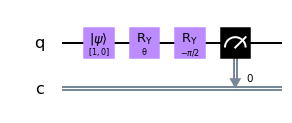

In [15]:
qc1.measure(0, 0)
qc2.measure(0, 0)

# We show the second circuit as an example
qc2.draw('mpl')

In [16]:
# We pick the simulator for counting
backend = Aer.get_backend('qasm_simulator')

# Now we repeat the experiments with a measurement at the end of the circuit
job1 = execute_parametrized_circuit(qc1, backend, num_shots, theta, theta_range)
job2 = execute_parametrized_circuit(qc2, backend, num_shots, theta, theta_range)

counts1 = job1.result().get_counts()
counts2 = job2.result().get_counts()

Finally we plot the counts for $0$ and $1$ for each experiment as a function of the rotation angle

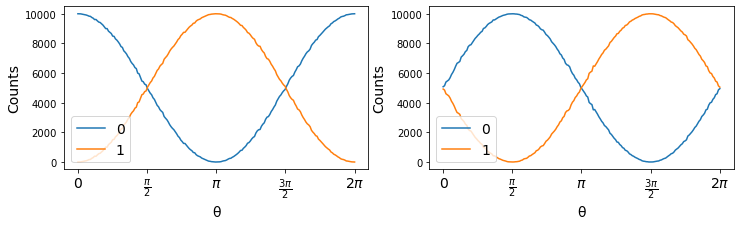

In [17]:
import matplotlib.pyplot as plt

# We plot the number of counts for 0 and 1
def counting_plot(axis, counts):
    
    axis.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '-', label='0')
    axis.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '-', label='1')
      
# Plot customization
def set_axis(axis, ylabel):

    axis.set_xticks([i * np.pi / 2 for i in range(5)])
    axis.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
    axis.set_xlabel('θ', fontsize=14)
    axis.set_ylabel(ylabel, fontsize=14)

    axis.legend(loc = "lower left", fontsize=14)

fig = plt.figure(figsize=(12,3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

counting_plot(ax1, counts1)
counting_plot(ax2, counts2)
set_axis(ax1, 'Counts')
set_axis(ax2, 'Counts')

plt.show()

## 2.1 Studying observables: Using the wave functions

Now that we drilled the basics into our heads, we'll try to do two things:

- We'll calculate the expected values and the eigenvalues directetly form the parametrized wave-function. This is not what the task (and the VQE) consists of but I will use it as a sanity check. We'll use this result to find out wether our "experimental" result, based directly on a measurement from the circuit, is consistent and correct

- We will do what was asked for in the problem assignment - we'll calculate the observable based on the measurement of the qubit registers. We'll begin with the simple example I gave above for $H = \sigma_x + \sigma_z$, then in section 3 we'll proceed to the harder matrix given in the problem statement.

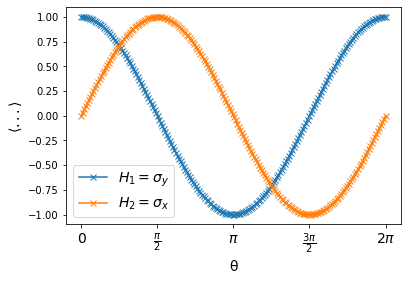

In [18]:
# We define eacu matrix/Hamiltonian term
H1 = np.array([[1, 0], [0, -1]])
H2 = np.array([[0, 1], [1, 0]])

# Here we calculate the expected value of an observable for each different experiment, for different values of theta sandwiching the observables between the wave function
expected_value_record1 = [np.transpose(wave_function[i]) @ H1 @ wave_function[i] for i in range(n_experiments)]
expected_value_record2 = [np.transpose(wave_function[i]) @ H2 @ wave_function[i] for i in range(n_experiments)]

#Here we take the real part to avoid warnings, we can have some negligible value in the imaginary part but this raises an alert anyway
expected_value_record1 = np.real(expected_value_record1)
expected_value_record2 = np.real(expected_value_record2)

#We plot the figure and extract the minimum
fig = plt.figure()
ax = fig.add_subplot()

# A plot for each term
ax.plot(theta_range, expected_value_record1, 'x-', label=r'$H_1 = \sigma_y$')
ax.plot(theta_range, expected_value_record2, 'x-', label=r'$H_2 = \sigma_x$')

# We set the frame and the appropriate labels
set_axis(ax, r'$\langle ... \rangle $')

plt.show()

Finally we sum over both of these contributions to plot the curve for $E(\theta) = \langle H \rangle_\theta$. The minimum will let us find the eigenvalue and the corresponding eigenvector. To find the eigenvector we simply substitute the value of $\theta$ which minimizes $E(\theta)$ into the Ansatz.

No handles with labels found to put in legend.


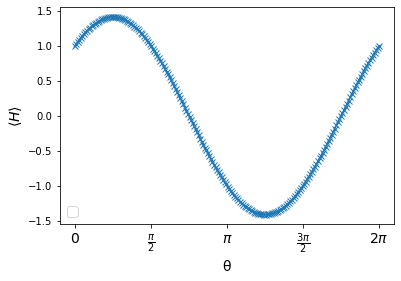

******************************************************************************** 
 The minimum is: -1.414114434440678 for 2θ = 1.24 π
 ********************************************************************************


In [19]:
expected_value_record = expected_value_record1 + expected_value_record2

#We plot the figure and extract the minimum
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(theta_range, expected_value_record, 'x-')
set_axis(ax, r'$\langle H \rangle $')

plt.show()

# Prints the minimum and the value of theta
print('*' * 80,'\n The minimum is:', min_eigen:= np.amin([expected_value_record]), 'for 2θ =', 2*np.where(expected_value_record == min_eigen)[0][0]/n_experiments,'π\n', '*' * 80)

## 2.2 Using the measurement scheme

Now we properly perform the VQE protocol, this time, actually implement the measurement, calculating the expected values from their distribution. To see the logic behind this, remember that if

\begin{equation}
\begin{matrix}
|\psi \rangle
=
\begin{pmatrix}
c_0\\
c_1\\
\end{pmatrix}
\end{matrix}
\end{equation}

We have 

\begin{equation}
\langle \sigma_z \rangle =c_0^2 - c_1^2
\end{equation}

So whenever we measure $0$ the contribution to the expected value will be positive, in the same spirit, the contribution of the number of counts for $c_1$ will be negative.

In [20]:
# The get method is pretty useful, it returns the value of the item with the specified key. In this case, we pick 0
# We then use this to convert the dictionary with results into a vector of probabilities
def get_probability(counts):
    
    return zip(
        list(map(lambda c: c.get('0', 0), counts)), 
        list(map(lambda c: c.get('1', 0), counts))
    )

# We return the normalized probability distribution for a certain ensemble size
def probability_distribution(counts, normalization):
    
    return [np.array([x,y])/normalization for x, y in get_probability(counts)]

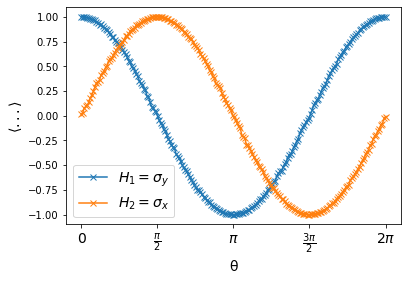

In [21]:
# We extract the distribution of counts for each experiment
distribution1 = probability_distribution(counts1, shots:= 10000)
distribution2 = probability_distribution(counts2, shots)

# We calculate the expected value from this counts, according to the equation in the text cell above
expected_value_record1 = np.array([distribution1[i][0] * 1 + distribution1[i][1] * -1 for i in range(n_experiments)])
expected_value_record2 = np.array([distribution2[i][0] * 1 + distribution2[i][1] * -1 for i in range(n_experiments)])

#We plot the figure and extract the minimum
fig = plt.figure()

ax = fig.add_subplot()

# The two curves
ax.plot(theta_range, expected_value_record1, 'x-', label=r'$H_1 = \sigma_y$')
ax.plot(theta_range, expected_value_record2, 'x-', label=r'$H_2 = \sigma_x$')

set_axis(ax, r'$\langle ... \rangle $')

plt.show()

Finally we sum the two contributions to obtain the same curve we found in the previous section, which shows that our curve is consistent:

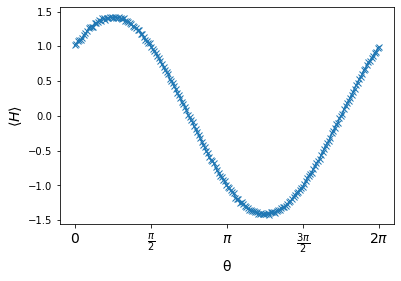

******************************************************************************** 
 The minimum is: -1.4198 for 2θ = 1.27 π
 ********************************************************************************


In [22]:
expected_value_record = expected_value_record1 + expected_value_record2

#We plot the figure and extract the minimum
fig = plt.figure()

ax = fig.add_subplot()

ax.plot(theta_range, expected_value_record, 'x-')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)

ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel(r'$\langle H \rangle $', fontsize=14)

plt.show()

# Prints the minimum and the value of theta
print('*' * 80,'\n The minimum is:', min_eigen:= np.amin([expected_value_record]), 'for 2θ =', 2*np.where(expected_value_record == min_eigen)[0][0]/n_experiments,'π\n', '*' * 80)

We should remember that the analytical solution is $\lambda = -\sqrt{2}$ with eigenvector 
$v_\lambda = \frac{1-\sqrt{2}}{\sqrt{4-2 \sqrt{2}}},\frac{1}{\sqrt{4-2 \sqrt{2}}} = (-0.382683, 0.92388)$, our results on the other
hand yield $\lambda = -1.4318$ and $v_\lambda = (\cos \left(\frac{1.23 \pi }{2}\right),\sin \left(\frac{1.23 \pi }{2}\right)) = (-0.368125, 0.929776)$ so it's pretty close to the analytical result!

# 3. The Task

## 3.1 A quick Mathematica Interlude - decomposing the Hamiltonian

Here I ran a short Mathematica code which I used to decompose the matrix into a Pauli basis. I chose to use Mathematica here since the language is symbolic, thus making the process much more concise and intuitive. In this section I also try to give a intuition for the used ansatz. First I define the Pauli Matrices and the tensor products in a symbolic manner. Then I ran a cell where I solved a system of equations for the coefficients. I also have a code for arbitrary matrices, which can find all the 16 coefficients, but I used a simplified version of the code for our ansatz for cleanliness (The whole Mathematica code will also be available on the github repository).

In [ ]:
(*Pauli Matrices definition*)
σ0 := {{1, 0}, {0, 1}}
σz := {{1, 0}, {0, -1}}
σx := {{0, 1}, {1, 0}}
σy := {{0, -I}, {I, 0}}

Symbolic definition for the tensor products

In [6]:
a_ ⊗ b_ := If[MatrixQ[a] == True, KroneckerProduct[a, b], Flatten @ KroneckerProduct[a, b]]

a_ ⊗ b_ ⊗ c__ := (a ⊗ b) ⊗ c

1    0    0    0

0    0    -1   0

0    -1   0    0

0    0    0    1
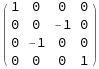

In [8]:
H:={{1, 0, 0, 0}, {0, 0, -1, 0}, {0, -1, 0, 0}, {0, 0, 0, 1}}
H // MatrixForm

Here we find all the coefficients

1       1         1          1
{{α -> -, β -> -, γ -> -(-), δ -> -(-)}}
       2       2         2          2
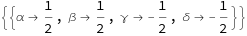

In [10]:
ClearAll[α, β, γ, δ];
Solution = Solve[H == α σ0 ⊗ σ0 + β σz ⊗ σz + γ σx ⊗ σx + δ σy ⊗ σy ,{α, β, γ, δ}]

And here we check our results:

1    0    0    0

0    0    -1   0

0    -1   0    0

0    0    0    1
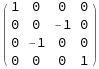

In [12]:
 α σ0 ⊗ σ0 + β σz ⊗ σz + γ σx ⊗ σx + δ σy ⊗ σy/.Solution[[1]]//MatrixForm

Therefore, this let us conclude that that Hamiltonian can be decomposed into:

\begin{equation}
H = \frac{1}{2} I \otimes I + \frac{1}{2} \sigma_z \otimes \sigma_z - \frac{1}{2} \sigma_x \otimes \sigma_x - \frac{1}{2} \sigma_y \otimes \sigma_y
\end{equation}

Let's first solve the eigenproblem to find out the analytical results. We can check in the computation below that the lowest eigenvalue is $\lambda = -1$ and $v_\lambda = \frac{1}{\sqrt{2}}(0, 1, 1, 0)$

{-1, 1, 1, 1}


0

   1
-------
Sqrt[2]

   1
-------
Sqrt[2]



0
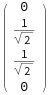

In [13]:
Eigenvalues[H]
Normalize[Eigenvectors[H][[1]]] // MatrixForm

Here we define the relevant gates for the circuit, moreover, we also study the action of the circuit on the qubits. It will be given by:

\begin{equation}
|\psi \rangle
=
(R_X(\theta)\otimes I)
C_X 
(H\otimes I) 
|0\rangle
|0\rangle
\end{equation}

This will be equal to:

\begin{equation}
\begin{matrix}
|\psi \rangle
=
\frac{1}{\sqrt{2}}
\begin{pmatrix}
\cos \left(\frac{\theta }{2}\right)\\
-i \sin \left(\frac{\theta }{2}\right)\\
-i \sin \left(\frac{\theta }{2}\right)\\
\cos \left(\frac{\theta }{2}\right)\\
\end{pmatrix}
\end{matrix}
\end{equation}

We can verify that this ansatz let us find the appropriate eigenvector, up to a phase factor of  $i$. We simply have to pick  $\theta = \pi$. 

This Ansatz makes a lot of sense after we think about it a little: the Haddamard gate makes the controlled gate non-trivial, since it doesn't act on the $| 00 \rangle$, which in turn introduces entanglement into the state, and in the end we introduce a gate with the variational parameters, just like we did before.

In [15]:
(*Here we define the controlled not, the haddamard and the RX gates*)
CX = ({
   {1, 0, 0, 0},
   {0, 1, 0, 0},
   {0, 0, 0, 1},
   {0, 0, 1, 0}
  }); HG = 1/Sqrt[2] ({
    {1, 1},
    {1, -1}
   }); RX[\[Theta]_] := ({
   {Cos[\[Theta]/2], -I Sin[\[Theta]/2]},
   {-I Sin[\[Theta]/2], Cos[\[Theta]/2]}
  })
ClearAll[U, \[Theta]]
U[\[Theta]_] := (RX[\[Theta]]\[CircleTimes]\[Sigma]0).CX1.(HG \[CircleTimes]\[Sigma]0);

Finally, we plot the expected value for the Hamiltonian as a function of the parameters. We can see that we indeed achieve the minimum at $\theta = \pi$ and that the lowest eigenvalue is indeed -1, and we get a wavefuction $| \psi(\theta = \pi) \rangle = i v_\lambda$, which correspond to the eigenvector we were looking for apart from a phase 

Thus, we should expect to find the very same plot with our quantum circuit in the next section

-Graphics-
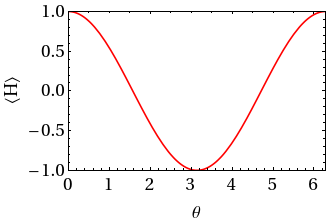

In [44]:
QAvg[\[Psi]_, O_] := Conjugate[\[Psi]].O.\[Psi]
Avgx = -0.5*
   QAvg[U[\[Theta]].({1, 0}\[CircleTimes]{1, 0}), 
    kron[\[Sigma]x, \[Sigma]x]];
Avgy = -0.5*
   QAvg[U[\[Theta]].({1, 0}\[CircleTimes]{1, 0}), 
    kron[\[Sigma]y, \[Sigma]y]];
Avgz = 0.5*
   QAvg[U[\[Theta]].({1, 0}\[CircleTimes]{1, 0}), 
    kron[\[Sigma]z, \[Sigma]z]];
Plot[0.5 + Avgx + Avgy + Avgz, {\[Theta], 0, 2 \[Pi]}, 
 PlotStyle -> {Red}, 
 FrameLabel -> {"\[Theta]", 
   "\[LeftAngleBracket]H\[RightAngleBracket]"}]

## 3.2 Setting up the circuit

We're finally in condition to implement the relevant quantum circuit to the problem. We'll begin by defining the pauli matrices and the double gates from the kronecker products

In [23]:
sigmaz = np.array([[1, 0], [0, -1]])
sigmax = np.array([[0, 1], [1, 0]])
sigmay = np.array([[0, -1j], [1j, 0]])

II = np.kron(np.identity(2), np.identity(2))
ZZ = np.kron(sigmaz, sigmaz)
XX = np.kron(sigmax, sigmax)
YY = np.real(np.kron(sigmay, sigmay))

H = np.array([[1, 0, 0, 0], [0, 0, -1, 0], [0, -1, 0, 0], [0, 0, 0, 1]])

Here we implement the circuit for the proposed Ansatz:

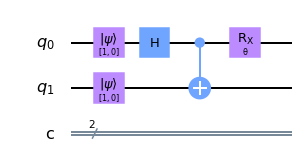

In [24]:
# We create two circuits with a single qubit
qc = QuantumCircuit(2, 2)

# We parametrize the wave function with a Y gate
qc.initialize([1, 0], 0) 
qc.initialize([1, 0], 1) 

theta = Parameter('θ')

# Haddamard gate, controlled not and Rx gate
qc.h(0)
qc.cx(0, 1)
qc.rx(theta, 0)

qc.draw('mpl')

Now we record the wave functions

In [25]:
backend = Aer.get_backend('statevector_simulator')

# We create several circuits with a binded parameter for a certain value of theta from the array above
circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

# We execute the job
job = execute(qc,
              backend, 
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])


wave_function = [job.result().get_statevector(i) for i in range (n_experiments)]

Now, **using the wave function**, we plot the contribution of each operator as a fuction of the variational angle

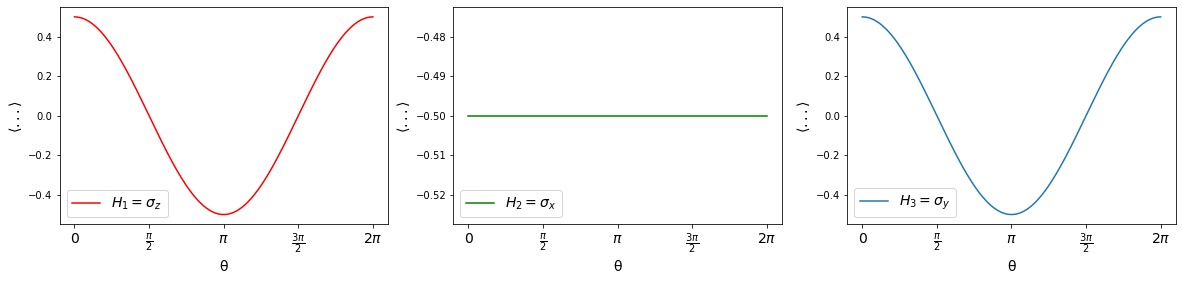

In [26]:
# We define each term in the Hamiltonian
H1 = 0.5 * ZZ
H2 = -0.5 * XX
H3 = -0.5 * YY

# Here we calculate the expected value of an observable for each different experiment, for different values of theta
expected_value_record1 = [np.matrix.getH(wave_function[i])@H1@wave_function[i] for i in range(n_experiments)]
expected_value_record2 = [np.matrix.getH(wave_function[i])@H2@wave_function[i] for i in range(n_experiments)]
expected_value_record3 = [np.matrix.getH(wave_function[i])@H3@wave_function[i] for i in range(n_experiments)]

# Here we take the real part to avoid warnings, we can have some negligible value in the imaginary part
expected_value_record1 = np.real(expected_value_record1)
expected_value_record2 = np.real(expected_value_record2)
expected_value_record3 = np.real(expected_value_record3)

#We plot the figure and extract the minimum
fig = plt.figure(figsize=(20,4))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(theta_range, expected_value_record1, '-', label=r'$H_1 = \sigma_z$', color = 'r')
ax2.plot(theta_range, expected_value_record2, '-', label=r'$H_2 = \sigma_x$', color = 'g')
ax3.plot(theta_range, expected_value_record3, '-', label=r'$H_3 = \sigma_y$')

set_axis(ax1, r'$\langle ... \rangle $')
set_axis(ax2, r'$\langle ... \rangle $')
set_axis(ax3, r'$\langle ... \rangle $')
    
plt.show()

Now we sum all these terms to find the total energy:

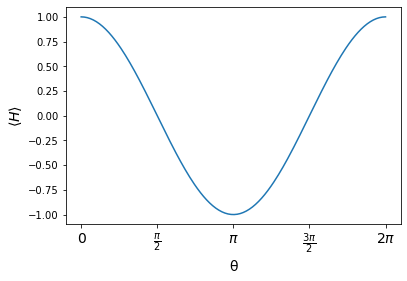

******************************************************************************** 
 The minimum is: -0.9998753895176573 for 2θ = 0.99 π
 ********************************************************************************


In [27]:
expected_value_record = 0.5 + expected_value_record1 + expected_value_record2 + expected_value_record3

#We plot the figure and extract the minimum
fig = plt.figure()

ax = fig.add_subplot()

ax.plot(theta_range, expected_value_record, '-')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)

ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel(r'$\langle H \rangle $', fontsize=14)

plt.show()

# Prints the minimum and the value of theta
print('*' * 80,'\n The minimum is:', min_eigen:= np.amin([expected_value_record]), 'for 2θ =', 2*np.where(expected_value_record == min_eigen)[0][0]/n_experiments,'π\n', '*' * 80)

So we got the result we were looking for! Let's implement the VQE for real now

## 3.3 Measurement Protocol

We begin by making three (deep) copies of the circuit. In the first one we simply perform the measurements, in the other two apply the $R_X$ and $R_Y$ gates before measuring.

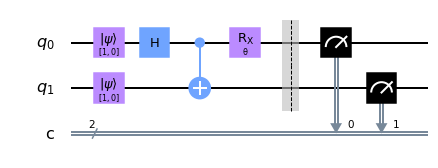

In [29]:
# We use the deep copy command to copy the circuit
import copy

qc = QuantumCircuit(2, 2)

# We parametrize the wave function with a Y gate
qc.initialize([1, 0], 0) 
qc.initialize([1, 0], 1) 

theta = Parameter('θ')

# Ansatz
qc.h(0)
qc.cx(0, 1)
qc.rx(theta, 0)
qc.barrier()

# It's important to perform a > deep < copy here otherwise all the three circuits will be modified at the same time
qc1 = copy.deepcopy(qc)

# We apply RY Gates to measure in the X basis
qc2 = copy.deepcopy(qc)
qc2.ry(-np.pi/2, 0)
qc2.ry(-np.pi/2, 1)

# We apply TX gates to measure in the Y basis
qc3 = copy.deepcopy(qc)
qc3.rx(-np.pi/2, 0)
qc3.rx(-np.pi/2, 1)

qc1.measure(0, 0)
qc1.measure(1, 1)

qc1.draw('mpl')

For the $\sigma_x \otimes \sigma_x$ term:

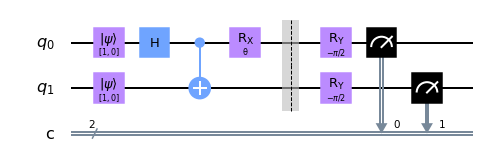

In [30]:
qc2.measure(0, 0)
qc2.measure(1, 1)

qc2.draw('mpl')

For the $\sigma_y \otimes \sigma_y$ term:

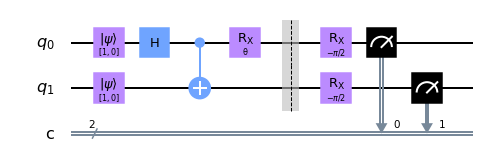

In [31]:
qc3.measure(0, 0)
qc3.measure(1, 1)

qc3.draw('mpl')

Now we simulate every circuit:

In [32]:
# We pick the simulator for counting
backend = Aer.get_backend('qasm_simulator')

job1 = execute_parametrized_circuit(qc1, backend, num_shots, theta, theta_range)
job2 = execute_parametrized_circuit(qc2, backend, num_shots, theta, theta_range)
job3 = execute_parametrized_circuit(qc3, backend, num_shots, theta, theta_range)

counts1 = job1.result().get_counts()
counts2 = job2.result().get_counts()
counts3 = job3.result().get_counts()

We plot the counts for each circuit:

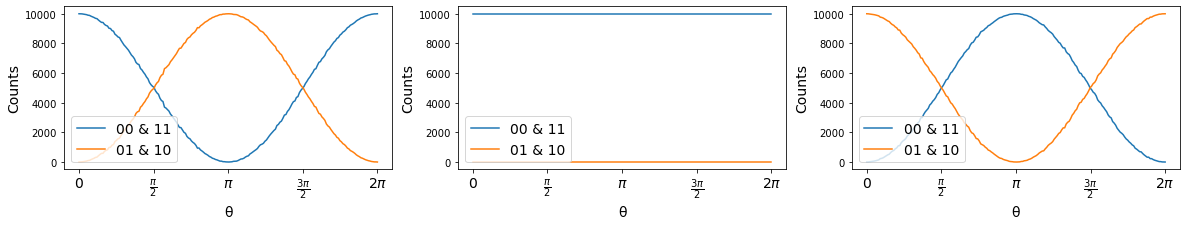

In [37]:
# We plot the number of counts for 00 & 11 and 01 and & 10, which will have positive and negative contributions, respectively 
def counting_plot(axis, counts):
    
    positive = np.array(list(map(lambda c: c.get('00', 0), counts))) +  np.array(list(map(lambda c: c.get('11', 0), counts)))
    negative = np.array(list(map(lambda c: c.get('01', 0), counts))) +  np.array(list(map(lambda c: c.get('10', 0), counts)))    
    axis.plot(theta_range, positive , '-', label='00 & 11')
    axis.plot(theta_range, negative, '-', label='01 & 10')
      
# Plot customization
def set_counting_axis(axis):

    axis.set_xticks([i * np.pi / 2 for i in range(5)])
    axis.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
    axis.set_xlabel('θ', fontsize=14)
    axis.set_ylabel('Counts', fontsize=14)

    axis.legend(loc = "lower left", fontsize=14)

fig = plt.figure(figsize=(20,3))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

counting_plot(ax1, counts1)
counting_plot(ax2, counts2)
counting_plot(ax3, counts3)
set_counting_axis(ax1)
set_counting_axis(ax2)
set_counting_axis(ax3)

plt.show()

Defining some auxiliary functions:

In [39]:
# The get method is pretty useful, it returns the value of the item with the specified key. In this case, we pick 0
# We then use this to convert the dictionary with results into a vector of probabilities
def get_probability(counts):
    
    positive = np.array(list(map(lambda c: c.get('00', 0), counts))) +  np.array(list(map(lambda c: c.get('11', 0), counts)))
    negative = np.array(list(map(lambda c: c.get('01', 0), counts))) +  np.array(list(map(lambda c: c.get('10', 0), counts))) 
    
    return zip(
        positive, 
        negative
    )

# We return the normalized probability distribution for a certain ensemble size
def probability_distribution(counts, normalization):
    
    return [np.array([x,y])/normalization for x, y in get_probability(counts)]

We can finally calculate the contribution from each curve (note that the plots here aren't balanced, we'll multiply by the appropriate weights in the end. That's why they differ a bit from the plots in the previous section):

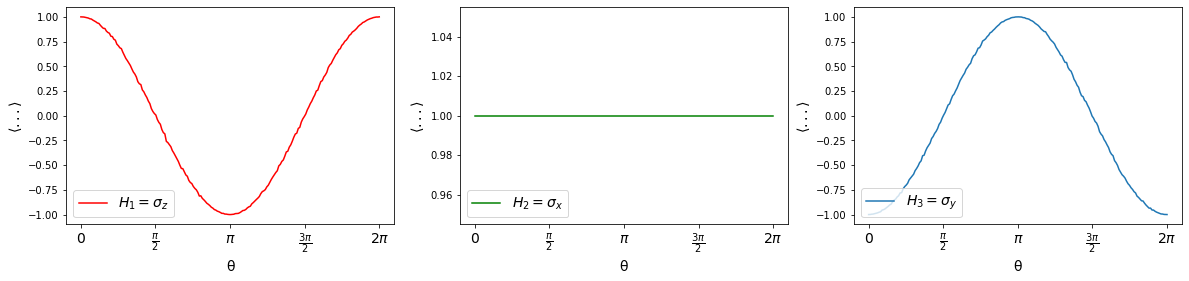

In [42]:
distribution1 = probability_distribution(counts1, shots:= 10000)
distribution2 = probability_distribution(counts2, shots)
distribution3 = probability_distribution(counts3, shots)

expected_value_record1 = np.array([distribution1[i][0] * 1 + distribution1[i][1] * -1 for i in range(n_experiments)])
expected_value_record2 = np.array([distribution2[i][0] * 1 + distribution2[i][1] * -1 for i in range(n_experiments)])
expected_value_record3 = np.array([distribution3[i][0] * 1 + distribution3[i][1] * -1 for i in range(n_experiments)])

fig = plt.figure(figsize=(20,4))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(theta_range, expected_value_record1, '-', label=r'$H_1 = \sigma_z$', color = 'r')
ax2.plot(theta_range, expected_value_record2, '-', label=r'$H_2 = \sigma_x$', color = 'g')
ax3.plot(theta_range, expected_value_record3, '-', label=r'$H_3 = \sigma_y$')

set_axis(ax1, r'$\langle ... \rangle $')
set_axis(ax2, r'$\langle ... \rangle $')
set_axis(ax3, r'$\langle ... \rangle $')
    
plt.show()

## 3.4 Main Result

Here we plot the energy curve as a function of the variational parameters. We brifly discuss the result below.

No handles with labels found to put in legend.


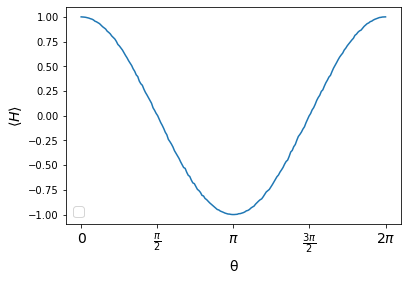

******************************************************************************** 
 The minimum is: -1.0 for 2θ = 0.99 π
 ********************************************************************************


In [43]:
# We compute the total energy properly weighting the expected value
expected_value_record = 0.5 + 0.5 * expected_value_record1 - 0.5 * expected_value_record2 - 0.5 * expected_value_record3

#We plot the figure and extract the minimum
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(theta_range, expected_value_record, '-')
set_axis(ax, r'$\langle H \rangle $')

plt.show()

# Prints the minimum and the value of theta
print('*' * 80,'\n The minimum is:', min_eigen:= np.amin([expected_value_record]), 'for 2θ =', 2*np.where(expected_value_record == min_eigen)[0][0]/n_experiments,'π\n', '*' * 80)

Thus, we can see that our VQE is working as expected! Our numerical result, based on measurements, coincides with both the wave function analysis and the analytical solution. (And as we explained before the factor of $2$ in $2\theta$ comes from the definition of the $R_X(\theta)$ gate in the qiskit library).

# 4. Further Analysis and Final Comments

## 4.1 Further Examples

### 4.1.1 A previous task

In this section I will show two more examples. In the first one we apply the VQE to the matrix given in the first cohort, which is available on the site. The matrix is:

\begin{equation}
H =
\begin{matrix}
\begin{pmatrix}
0 & 0 & 0 & 0\\
0& -1 & 1 & 0\\
0& 1 & -1 & 0\\
0 & 0 & 0 & 0\\
\end{pmatrix}
\end{matrix}
\end{equation}

which can be decomposed as

\begin{equation}
H = - \frac{1}{2} I \otimes I + \frac{1}{2} \sigma_z \otimes \sigma_z + \frac{1}{2} \sigma_x \otimes \sigma_x + \frac{1}{2} \sigma_y \otimes \sigma_y
\end{equation}

The lowest eigenvalue is $\lambda = -2$ with eigenvector:

\begin{equation}
v_\lambda = 
\frac{1}{\sqrt{2}}
\begin{matrix}
\begin{pmatrix}
0 \\
-1 \\
1 \\
0 \\
\end{pmatrix}
\end{matrix}
\end{equation}

we'll look for an Ansatz of the form

\begin{equation}
|\psi \rangle
=
(I \otimes X) 
C_X 
(R_Z(\theta)\otimes I)
(H\otimes I) 
|0\rangle
|0\rangle
\end{equation}

I think it's interesting to once again discuss what each gate does here. We first apply the Haddamard gate to introduce a superposition of states:

\begin{equation}
(H\otimes I) 
|0\rangle
|0\rangle
=
\frac{1}{\sqrt{2}}
\begin{matrix}
\begin{pmatrix}
1 \\
0 \\
1 \\
0 \\
\end{pmatrix}
\end{matrix}
\end{equation}

Then we introduce the variational parameters, which will generate a phase factor in one of the terms (I will factor the phase out from now on whenever possible, I think it's easier to see where our "degrees of freedom" are in this way. We're basically messing with $\theta$ in order to assign a specific value to one of the components):

\begin{equation}
(R_Z(\theta)\otimes I)
(H\otimes I) 
|0\rangle
|0\rangle
=
\frac{e^{- i \theta/2}}{\sqrt{2}}
\begin{matrix}
\begin{pmatrix}
1 \\
0 \\
e^{i \theta} \\
0 \\
\end{pmatrix}
\end{matrix}
\end{equation}

Later, we apply the $CX$ gate to introduce entanglement into the system

\begin{equation}
C_X
(H\otimes I) 
|0\rangle
|0\rangle
=
\frac{e^{- i \theta/2}}{\sqrt{2}}
\begin{matrix}
\begin{pmatrix}
1 \\
0 \\
0 \\
e^{i \theta} \\
\end{pmatrix}
\end{matrix}
\end{equation}

However, we don't wanna entanglement in $|0\rangle|0\rangle$ and $|1\rangle|1\rangle$ but rather on $|0\rangle|1\rangle$ and $|1\rangle|0\rangle$, so we apply a bit-flip gate onto the second qubit, to arrive at our desired Ansatz:

\begin{equation}
|\psi \rangle
=
(I \otimes X) 
C_X 
(R_Z(\theta)\otimes I)
(H\otimes I) 
|0\rangle
|0\rangle
=
\frac{e^{- i \theta/2}}{\sqrt{2}}
\begin{matrix}
\begin{pmatrix}
0 \\
1 \\
e^{i \theta} \\
0 \\
\end{pmatrix}
\end{matrix}
\end{equation}

So it's clear that we have to pick $\theta = \pi$. I chose two discuss this Ansatz in more detail since it's slightly more complex than the previous one, so I thought the discussion would be more fruitful here.

Now that we have discussed the physics behind this choice of Ansatz let's move onto the circuit implementation:

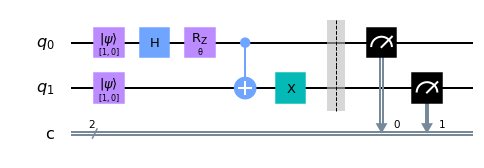

In [44]:
qc = QuantumCircuit(2, 2)
qc.initialize([1, 0], 0) 
qc.initialize([1, 0], 1) 

# Ansatz
qc.h(0)
qc.rz(theta, 0)
qc.cx(0, 1)
qc.x(1)
qc.barrier()

qc1 = copy.deepcopy(qc)

# We apply RY Gates to measure in the X basis
qc2 = copy.deepcopy(qc)
qc2.ry(-np.pi/2, 0)
qc2.ry(-np.pi/2, 1)

# We apply RX gates to measure in the Y basis
qc3 = copy.deepcopy(qc)
qc3.rx(-np.pi/2, 0)
qc3.rx(-np.pi/2, 1)

# For the ZZ term
qc1.measure(0, 0)
qc1.measure(1, 1)

# For the XX term
qc2.measure(0, 0)
qc2.measure(1, 1)

# For the YY terms
qc3.measure(0, 0)
qc3.measure(1, 1)

qc1.draw('mpl')

In [45]:
# We pick the simulator for counting
backend = Aer.get_backend('qasm_simulator')

job1 = execute_parametrized_circuit(qc1, backend, num_shots, theta, theta_range)
job2 = execute_parametrized_circuit(qc2, backend, num_shots, theta, theta_range)
job3 = execute_parametrized_circuit(qc3, backend, num_shots, theta, theta_range)

counts1 = job1.result().get_counts()
counts2 = job2.result().get_counts()
counts3 = job3.result().get_counts()

In [46]:
distribution1 = probability_distribution(counts1, shots:= 10000)
distribution2 = probability_distribution(counts2, shots)
distribution3 = probability_distribution(counts3, shots)

expected_value_record1 = np.array([distribution1[i][0] * 1 + distribution1[i][1] * -1 for i in range(n_experiments)])
expected_value_record2 = np.array([distribution2[i][0] * 1 + distribution2[i][1] * -1 for i in range(n_experiments)])
expected_value_record3 = np.array([distribution3[i][0] * 1 + distribution3[i][1] * -1 for i in range(n_experiments)])

No handles with labels found to put in legend.


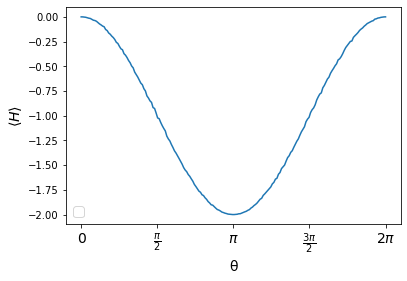

******************************************************************************** 
 The minimum is: -1.9999 for 2θ = 0.99 π
 ********************************************************************************


In [47]:
# We compute the total energy properly weighting the expected value
expected_value_record = - 0.5 + 0.5 * expected_value_record1 + 0.5 * expected_value_record2 + 0.5 * expected_value_record3

#We plot the figure and extract the minimum
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(theta_range, expected_value_record, '-')
set_axis(ax, r'$\langle H \rangle $')

plt.show()

# Prints the minimum and the value of theta
print('*' * 80,'\n The minimum is:', min_eigen:= np.amin([expected_value_record]), 'for 2θ =', 2*np.where(expected_value_record == min_eigen)[0][0]/n_experiments,'π\n', '*' * 80)

### 4.1.2 My own example

I tried to think about an example which would be different, but only *slightly*, from the previous one. Here I try to justify my own Ansatz choice, based on our last discussion. My matrix of choice, for simplicity, was:

\begin{equation}
H =
\begin{matrix}
\begin{pmatrix}
1 & 0 & 0 & -i\\
0& -1 & i & 0\\
0& -i & -1 & 0\\
i & 0 & 0 & 1\\
\end{pmatrix}
\end{matrix}
\end{equation}

which can be decomposed as

\begin{equation}
H = \sigma_z \otimes \sigma_z + \sigma_x \otimes \sigma_y
\end{equation}

The lowest eigenvalue is $\lambda = -2$ with eigenvector:

\begin{equation}
v_\lambda = 
\frac{1}{\sqrt{2}}
\begin{matrix}
\begin{pmatrix}
0 \\
-i \\
1 \\
0 \\
\end{pmatrix}
\end{matrix}
\end{equation}

This eigenvector is pretty similar to the previous one, but this time the components are $\pi/2$ and not $\pi$ degrees apart from each other on the complex plane, so I tried to introduce a new $R_Z(-\pi/2)$ gate to deal with it, so we'll look for an Ansatz of the form

\begin{equation}
|\psi \rangle
=
(I \otimes X) 
C_X 
(R_Z(\theta)\otimes I)
(R_Z(-\pi/2)\otimes I)
(H\otimes I) 
|0\rangle
|0\rangle
\end{equation}

The resulting Ansatz will have the form

\begin{equation}
|\psi \rangle
=
\frac{e^{- i (\frac{\pi}{4} +  \frac{\theta}{2})}}{\sqrt{2}}
\begin{matrix}
\begin{pmatrix}
0 \\
e^{i(\theta + \frac{\pi}{2})} \\
1 \\
0 \\
\end{pmatrix}
\end{matrix}
\end{equation}

So it's clear that by choosing $\theta = \pi$ we get the desired factor of $-i$ in the free component in the vector above, and we're done. We find the same results below using VQE!

There's one last subtlety in this example. This time we have a $ \sigma_x \otimes \sigma_y$ term in the Hamiltonian, so this time we don't use repeated gates, but instead we have to rotate the first qubit using a $R_Y$ gate and the other one using a $R_X$ gate to perform the measurement! This happens because we want to convert the eigenstate $|+\rangle|+i\rangle$ into $|0\rangle |0\rangle$ an so on!

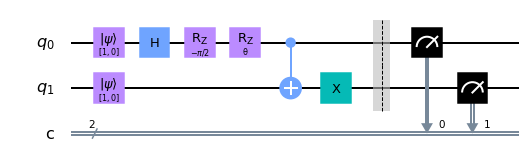

In [48]:
qc = QuantumCircuit(2, 2)

# We parametrize the wave function with a Y gate
qc.initialize([1, 0], 0) 
qc.initialize([1, 0], 1) 

theta = Parameter('θ')

# Ansatz
qc.h(0)
qc.rz(-np.pi/2, 0)
qc.rz(theta, 0)
qc.cx(0, 1)
qc.x(1)
qc.barrier()

qc1 = copy.deepcopy(qc)

# We apply a RY Gate to measure in the X basis and a RX the gate to the second qubit!
qc2 = copy.deepcopy(qc)
qc2.ry(-np.pi/2, 1)
qc2.rx(-np.pi/2, 0)

qc1.measure(0, 0)
qc1.measure(1, 1)

qc2.measure(0, 0)
qc2.measure(1, 1)

qc1.draw('mpl')

In [49]:
# We pick the simulator for counting
backend = Aer.get_backend('qasm_simulator')

job1 = execute_parametrized_circuit(qc1, backend, num_shots, theta, theta_range)
job2 = execute_parametrized_circuit(qc2, backend, num_shots, theta, theta_range)

counts1 = job1.result().get_counts()
counts2 = job2.result().get_counts()

In [50]:
distribution1 = probability_distribution(counts1, shots:= 10000)
distribution2 = probability_distribution(counts2, shots)

expected_value_record1 = np.array([distribution1[i][0] * 1 + distribution1[i][1] * -1 for i in range(n_experiments)])
expected_value_record2 = np.array([distribution2[i][0] * 1 + distribution2[i][1] * -1 for i in range(n_experiments)])

No handles with labels found to put in legend.


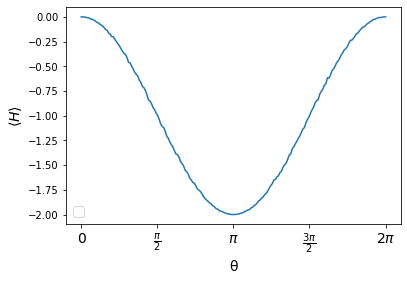

******************************************************************************** 
 The minimum is: -2.0 for 2θ = 1.0 π
 ********************************************************************************


In [51]:
# We compute the total energy properly weighting the expected value
expected_value_record =  expected_value_record1 + expected_value_record2 

#We plot the figure and extract the minimum
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(theta_range, expected_value_record, '-')
set_axis(ax, r'$\langle H \rangle $')

plt.show()

# Prints the minimum and the value of theta
print('*' * 80,'\n The minimum is:', min_eigen:= np.amin([expected_value_record]), 'for 2θ =', 2*np.where(expected_value_record == min_eigen)[0][0]/n_experiments,'π\n', '*' * 80)

## 4.2 Some Generalizations which could  be done

- We could further study Ansatzes. It's not trivial how to pick a good Ansatz. In the last example we could do it because we saw a pretty similar example before hand and we also knew the analytical solution, so it's easier to juggle with gates in order to find ansatzes which yield eigenvectors with your desired form

- We could introduce noise into the circuit and try to study how it affects the performance

- It would be nice to perform a comparison with classical methods for benchmarking purposes. It's not entirely clear when and how much advantageous the VQE is. I also would like to introduce more robust techniques like the gradient descent and so on when optimizing the variational parameters